In [ ]:
!pip install ortools
import random
import numpy as np
import pandas as pd
import math
from matplotlib import pyplot as plt
from scipy.spatial import distance_matrix
import seaborn
from ortools.constraint_solver import pywrapcp

random.seed(40)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 16.0 MB 297 kB/s 
     |████████████████████████████████| 408 kB 35.9 MB/s 
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.17.3
    Uninstalling protobuf-3.17.3:
      Successfully uninstalled protobuf-3.17.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.2+zzzcolab20220719082949 requires protobuf<3.20,>=3.9.2, but you have protobuf 4.21.5 which is incompatible.
tensorflow-metadata 1.9.0 requires protobuf<4,>=3.13, but you have protobuf 4.21.5 which is incompatible.
google-cloud-bigquery-storage 1.1.2 requires protobuf<4.0.0dev, but you have protobuf 4.21.5 which is incompatible.
google-api-core 1.31.6 requires protobuf<4.0.0dev,>=3.12.0; python_version > "3", but you have protob

In [ ]:
# wt_count = 25
cable_max = 7
power_generated = 1
loop_count = 4
# x_coordinates = [50]
# y_coordinates = [50]
# for i in range(wt_count-1):
#   x_coordinates.append(np.random.randint(0,100))
#   y_coordinates.append(np.random.randint(0,100))

In [ ]:

x_coordinates = [1168, 350,511,668,838,236,389,554,696,1117,1274,1447,841,995,1140,1286,1420,1495,1605,1790,1664,1825,1982,2112]
y_coordinates = [967, 653,  712,  771,  838,  995,  1050,  1117,  1172,  566,  617,  692,  1227,  1282,  1325,  1377,  1447,  1074,  743,  814,  1140,  1219,  1274,  936]

wt_count = len(x_coordinates)
wt_count

24

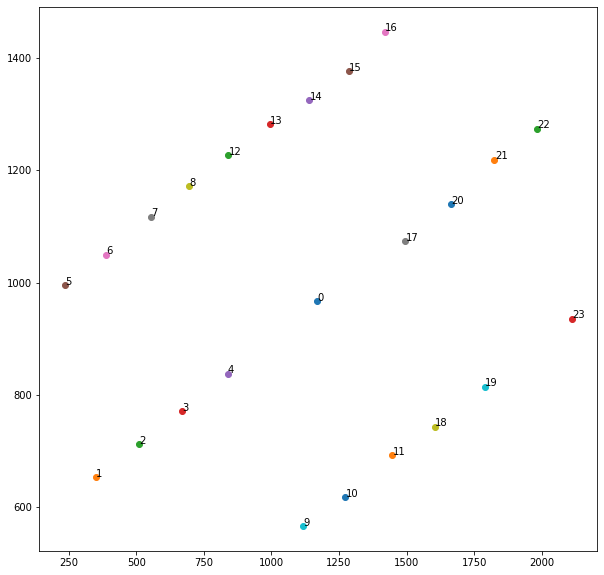

In [ ]:
plt.figure(figsize=(10,10))
for i in range(wt_count):    
  plt.scatter(x_coordinates[i], y_coordinates[i])
  plt.text(x_coordinates[i]+1, y_coordinates[i]+1, i)

In [ ]:
# distance matrixに2ノード間ののmanhattan distanceを記録する
distance_matrix = []
for i in range(wt_count):
  distance_array = []
  for j in range(wt_count):
    distance_array.append(abs(x_coordinates[i]-x_coordinates[j]) + abs(y_coordinates[i]-y_coordinates[j]))
  distance_matrix.append(distance_array)

In [ ]:
# 各WTについてそのWTで発電される電力量を記録するarray "generated"を作成
generated = [0]
for i in range(wt_count-1):
  generated.append(power_generated)

In [ ]:
# pywrapcp.RoutingModelが求めるdataの形にdataを整形
def create_data_model():
  data = {}
  data['distance_matrix'] = distance_matrix
  # maximum num of vehicles
  data['num_vehicles'] = loop_count
  # index of depot
  data['depot'] = 0
  data['generated'] = generated
  return data

In [ ]:
def distance_callback(from_index, to_index):
    """Returns the distance between the two nodes."""
    # Convert from routing variable Index to distance matrix NodeIndex.
    from_node = manager.IndexToNode(from_index)
    to_node = manager.IndexToNode(to_index)
    return data['distance_matrix'][from_node][to_node]

In [ ]:
def print_solution(data, manager, routing, solution):
    print(f'Objective: {solution.ObjectiveValue()}')
    # max_route_distance = 0
    for vehicle_id in range(data['num_vehicles']):
      index = routing.Start(vehicle_id)
      plan_output = 'Route for vehicle {}:\n'.format(vehicle_id)
      route_distance = 0
      while not routing.IsEnd(index):
          plan_output += ' {} -> '.format(manager.IndexToNode(index))
          previous_index = index
          index = solution.Value(routing.NextVar(index))
          route_distance += routing.GetArcCostForVehicle(
              previous_index, index, vehicle_id)
      plan_output += '{}\n'.format(manager.IndexToNode(index))
      plan_output += 'Distance of the route: {}m\n'.format(route_distance)

    #     max_route_distance = max(route_distance, max_route_distance)
    # print('Maximum of the route distances: {}m'.format(max_route_distance))
def output_loops(data, manager, routing, solution):
  loops = []
  for vehicle_id in range(data['num_vehicles']):
    loop = []
    index = routing.Start(vehicle_id)
    while not routing.IsEnd(index):
      loop.append(manager.IndexToNode(index))
      index = solution.Value(routing.NextVar(index))
    loops.append(loop)
  return loops

def draw_map(loops):
  plt.figure(figsize=(10,10))
  for i in range(wt_count):    
    plt.scatter(x_coordinates[i], y_coordinates[i])
    plt.text(x_coordinates[i], y_coordinates[i], i)
  for loop in loops:
    for node_index in range(-1,len(loop)-1):
      plt.plot([x_coordinates[loop[node_index]], x_coordinates[loop[node_index+1]]], [y_coordinates[loop[node_index]], y_coordinates[loop[node_index+1]]], c="black")

def loops_to_arcs(loops):
  arcs = []
  for loop in loops:
    loop.append(0)
  for loop in loops:
    for edge_index in range(len(loop)-1):
      arcs.append([loop[edge_index],loop[edge_index+1]])
  return arcs

def cable_loss_matrix(loops):
  for

[[0, 24, 8, 18, 14, 11, 20, 15], [0, 19, 12, 17, 4, 10, 13, 5], [0, 9, 16, 22, 2, 23, 1, 21], [0, 3, 7, 6]]

In [ ]:
def main():
  data = create_data_model()
  manager = pywrapcp.RoutingIndexManager(len(data['distance_matrix']),
                                          data['num_vehicles'], data['depot'])
  routing = pywrapcp.RoutingModel(manager)

  # optimizerが使用するindexから可読可能ななnodeに変換し距離を計算する距離callback
  def distance_callback(from_index, to_index):
    from_node = manager.IndexToNode(from_index)
    to_node = manager.IndexToNode(to_index)
    return data['distance_matrix'][from_node][to_node]

  # 距離callbackをRoutingModelに登録
  transit_callback_index = routing.RegisterTransitCallback(distance_callback)

  # ここでcostを定義。もし送電ロスを計算する場合ここに算入する
  # DocumentationにおいてSetArcCost...というfunctionを漁ればわかる？
  # transit_callback_indexは「距離距離callbackをRoutingModelに登録」しているが、costと別のものにすることは可能なのか？要リサーチ

  routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

  # あるWind Turbineから回収される電力量を算出。この例でへ一定としてdataに定める値25にする。
  def demand_callback(index):
      node = manager.IndexToNode(index)
      return data['generated'][node]

  # 上で定義したかくWTで回収した電力量ををroutingモデルに追加
  demand_callback_index = routing.RegisterUnaryTransitCallback(demand_callback)

  # ケーブルのキャパシティの制約
  routing.AddDimensionWithVehicleCapacity(
    demand_callback_index,
    0,  # slack変数（おそらく0でいい）ref. https://developers.google.com/optimization/routing/dimensions
    [cable_max,cable_max,cable_max,cable_max],  # array cableが運べるmax
    True,  # loopはcapacity 0からスタート
    'generated')
  
  search_parameters = pywrapcp.DefaultRoutingSearchParameters()

  # 上で定義したケーブルのキャパシティの制約をモデルに追加
  capacity = routing.GetDimensionOrDie('generated')

  # 探索を行うパラメータを定義
  search_parameters = pywrapcp.DefaultRoutingSearchParameters()

  # 探索の上限時間の設定
  search_parameters.time_limit.seconds = 30

  # 探索制限時間内
  solution = routing.SolveWithParameters(search_parameters)

  if solution:
    print_solution(data, manager, routing, solution)
    loops = output_loops(data, manager, routing, solution)
    draw_map(loops)
    print(loops_to_arcs(loops))

  else: 
    print('No solution found !')



Objective: 9960
[[0, 14], [14, 15], [15, 16], [16, 0], [0, 11], [11, 10], [10, 9], [9, 1], [1, 2], [2, 3], [3, 4], [4, 0], [0, 17], [17, 20], [20, 21], [21, 22], [22, 23], [23, 19], [19, 18], [18, 0], [0, 13], [13, 12], [12, 8], [8, 7], [7, 6], [6, 5], [5, 0]]


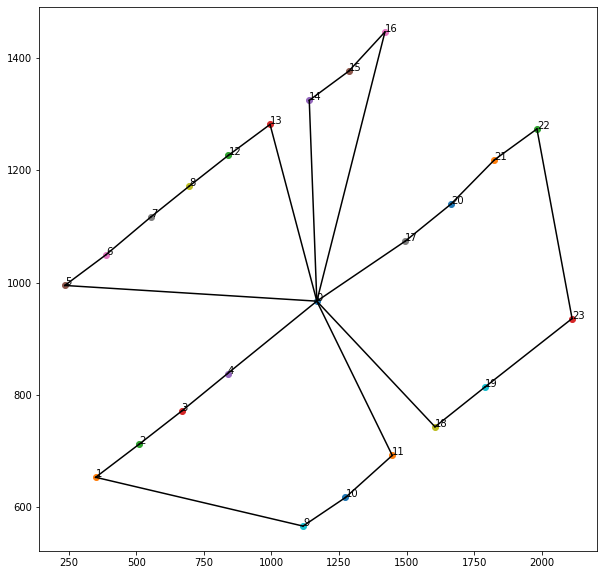

In [ ]:
if __name__ == '__main__':
    main()

In [ ]:
distance_matrix

[[0,
  1132,
  912,
  696,
  459,
  960,
  862,
  764,
  677,
  452,
  456,
  554,
  587,
  488,
  386,
  528,
  732,
  434,
  661,
  775,
  669,
  909,
  1121,
  975],
 [1132,
  0,
  220,
  436,
  673,
  456,
  436,
  668,
  865,
  854,
  960,
  1136,
  1065,
  1274,
  1462,
  1660,
  1864,
  1566,
  1345,
  1601,
  1801,
  2041,
  2253,
  2045],
 [912,
  220,
  0,
  216,
  453,
  558,
  460,
  448,
  645,
  752,
  858,
  956,
  845,
  1054,
  1242,
  1440,
  1644,
  1346,
  1125,
  1381,
  1581,
  1821,
  2033,
  1825],
 [696,
  436,
  216,
  0,
  237,
  656,
  558,
  460,
  429,
  654,
  760,
  858,
  629,
  838,
  1026,
  1224,
  1428,
  1130,
  965,
  1165,
  1365,
  1605,
  1817,
  1609],
 [459,
  673,
  453,
  237,
  0,
  759,
  661,
  563,
  476,
  551,
  657,
  755,
  392,
  601,
  789,
  987,
  1191,
  893,
  862,
  976,
  1128,
  1368,
  1580,
  1372],
 [960,
  456,
  558,
  656,
  759,
  0,
  208,
  440,
  637,
  1310,
  1416,
  1514,
  837,
  1046,
  1234,
  1432,
  1636,
